In [1]:
from codes.deep_learning.download_model import download_and_save_hugging_face_models,train_model
from codes.deep_learning.predict_on_model import predict_on_tuned_model, predict_on_roberta,predict_on_vader
from codes.loading_and_filtering.parameters import categories
from codes.loading_and_filtering.data_loader import load_reviews
from codes.deep_learning.preprocessing import map_ratings_into_sentiment
#Run once on the beginning 
#download_and_save_hugging_face_models()

category = categories[32]
data = load_reviews(category).head(10000)
data = data[data["text"].str.split().str.len() >= 1]
data = map_ratings_into_sentiment(data, positive_threshold=4)
data

,rating,text,parent_asin,timestamp,star_based_sentiment
0,4.0,I’m playing on ps5 and it’s interesting. It’s...,B07DK1H3H5,2020-12-17 06:33:24.795,1
1,5.0,Nostalgic fun. A bit slow. I hope they don’t...,B07SRWRH5D,2020-04-16 15:31:54.941,1
2,5.0,This was an order for my kids & they have real...,B07MFMFW34,2017-03-30 12:37:11.000,1
3,5.0,"These work great, They use batteries which is ...",B0BCHWZX95,2019-12-29 16:40:34.017,1
4,5.0,I would recommend to anyone looking to add jus...,B00HUWA45W,2015-03-29 01:18:52.000,1
...,...,...,...,...,...
9995,3.0,"Works well, and is very fun to play! I have no...",B00VG3PUFA,2018-09-13 13:00:27.630,0
9996,5.0,Ordered to replace the cord on PlayStation 4. ...,B0BDWVBWC9,2022-02-25 20:27:23.135,1
9997,5.0,Not even a Star Wars fan…still really good game.,B07QQTJMRF,2021-08-22 02:13:50.441,1
9998,2.0,Booooo!,B07NVTR5FD,2021-08-22 02:13:03.833,0


Analiza recenzji i jak się zmieniały oceny w czasie

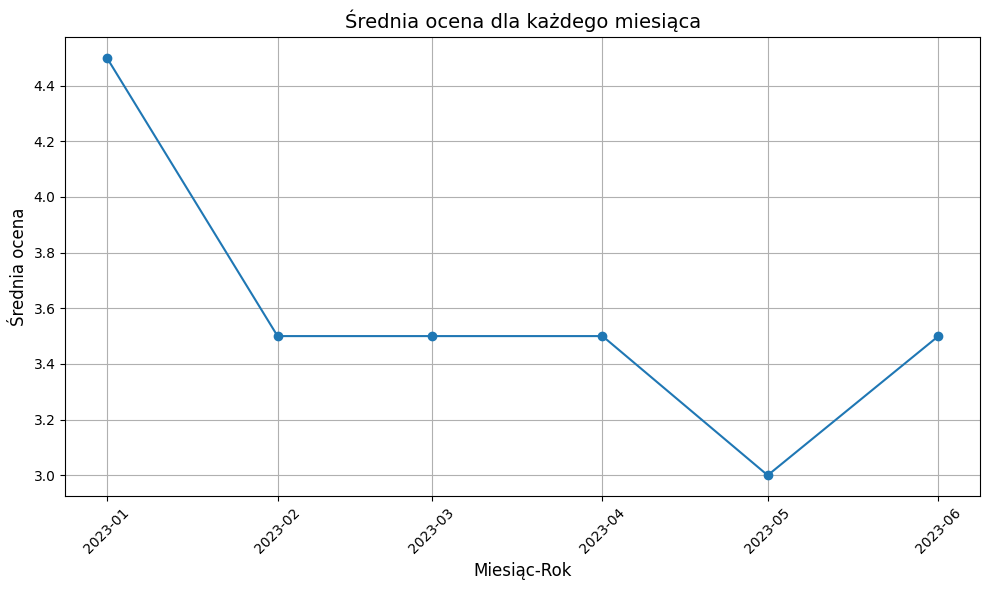

In [8]:
def plot_monthly_avg(df):
  
    # Konwersja kolumny 'data' na typ datetime
    data['date'] = pd.to_datetime(df['timestamp'])

    # Dodanie kolumny z miesiącem i rokiem w formacie 'MM-YYYY'
    data['date'] = data['date'].dt.to_period('M').astype(str)

    # Grupowanie po 'miesiac-rok' i obliczanie średniej oceny
    srednie_oceny = data.groupby('date')['label'].mean().reset_index()

    # Sortowanie danych po miesiącach
    srednie_oceny['miesiac-rok'] = pd.to_datetime(srednie_oceny['miesiac-rok'], format='%Y-%m')
    srednie_oceny = srednie_oceny.sort_values('miesiac-rok')

    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))
    plt.plot(srednie_oceny['miesiac-rok'], srednie_oceny['ocena'], marker='o', linestyle='-')
    plt.title('Średnia ocena dla każdego miesiąca', fontsize=14)
    plt.xlabel('Miesiąc-Rok', fontsize=12)
    plt.ylabel('Średnia ocena', fontsize=12)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Wyświetlenie wykresu
    plt.show()

# Przykładowe użycie
# Tworzenie przykładowych danych
data = pd.DataFrame({
    'ocena': [4, 5, 3, 4, 5, 2, 3, 4, 5, 1, 4, 3],
    'data': ['2023-01-01', '2023-01-15', '2023-02-01', '2023-02-15',
             '2023-03-01', '2023-03-15', '2023-04-01', '2023-04-15',
             '2023-05-01', '2023-05-15', '2023-06-01', '2023-06-15']
})

# Wywołanie funkcji
plot_monthly_avg(data)

Modele do predykcji rating lub sentymentu

Typowa klasyfikacja z CrossEntropyLoss

In [15]:
data["target"] = [int(x)-1 for x in data["rating"]]
train_model(data,target="target",num_classes=5, localname="video_games_test")

Epoch 1/3, Train Loss: 0.8409, Val Loss: 0.7246, Val Accuracy: 0.7219
Epoch 2/3, Train Loss: 0.6236, Val Loss: 0.7298, Val Accuracy: 0.7154
No improvement for 1 epochs. Patience: 3
Epoch 3/3, Train Loss: 0.4834, Val Loss: 0.8128, Val Accuracy: 0.7034
No improvement for 2 epochs. Patience: 3


c:\Users\Michał\Inżynierka\Diploma-Project-Sentiment-analysis-based-on-products-reviews\codes\deep_learning\download_model.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

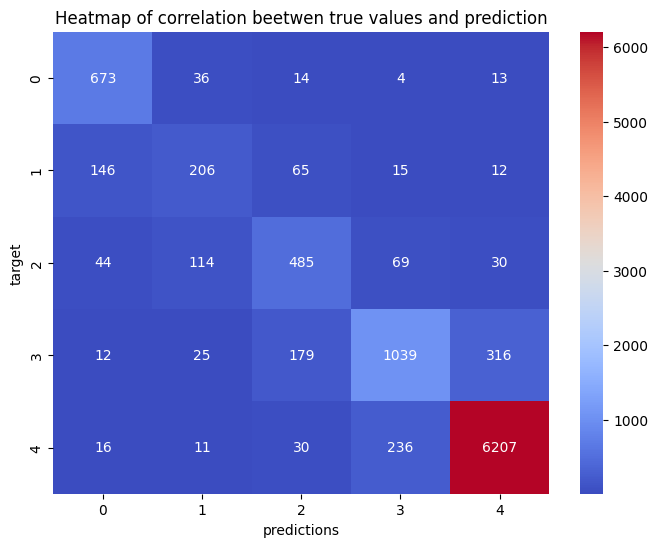

In [22]:
from codes.deep_learning.rating_analysis import heatmap
data["predictions"]=predict_on_tuned_model(data,r".\models\classification\video_games_test")
heatmap(data,"target","predictions")

Podejście regresyjne z MSELoss i mapowaniem ratingu na przedział [0,1] (Do poprawy, zapomniałem o sigmoidzie na koniec więc pomimo, że się uczy to może wyjść poza przedział)

In [31]:
data["target"]=(data["rating"]-1)/4
train_model(data,target="target",task="regression",num_classes=5, localname="video_games_test")

Epoch 1/3, Train Loss: 0.0473, Val Loss: 0.0360, Val Accuracy: 0.6923
Epoch 2/3, Train Loss: 0.0247, Val Loss: 0.0328, Val Accuracy: 0.7134
Epoch 3/3, Train Loss: 0.0152, Val Loss: 0.0388, Val Accuracy: 0.7164
No improvement for 1 epochs. Patience: 3


c:\Users\Michał\Inżynierka\Diploma-Project-Sentiment-analysis-based-on-products-reviews\codes\deep_learning\download_model.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

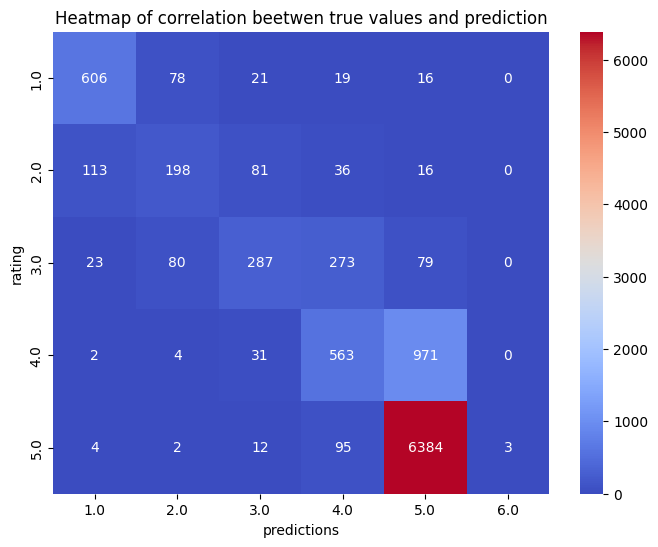

In [3]:
from codes.deep_learning.rating_analysis import heatmap
data["predictions"]=predict_on_tuned_model(data,r".\models\regression\video_games_test")
heatmap(data,"rating","predictions")

Wykorzystanie ratingu do predykcji sentymentu za pomocą mapowania gwiazdek na positive/negative

In [4]:
train_model(data,target="star_based_sentiment",num_classes=2, localname="video_games_test")

Epoch 1/3, Train Loss: 0.2725, Val Loss: 0.1991, Val Accuracy: 0.9155
Epoch 2/3, Train Loss: 0.1500, Val Loss: 0.2622, Val Accuracy: 0.9045
No improvement for 1 epochs. Patience: 3
Epoch 3/3, Train Loss: 0.0870, Val Loss: 0.2410, Val Accuracy: 0.9125
No improvement for 2 epochs. Patience: 3


c:\Users\Michał\Inżynierka\Diploma-Project-Sentiment-analysis-based-on-products-reviews\codes\deep_learning\download_model.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

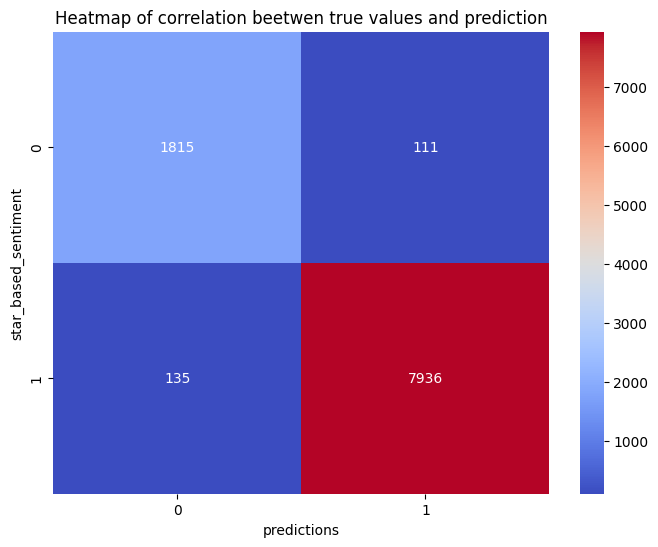

In [5]:
data["predictions"]=predict_on_tuned_model(data,r".\models\sentiment_prediction\video_games_test")
heatmap(data,"star_based_sentiment","predictions")

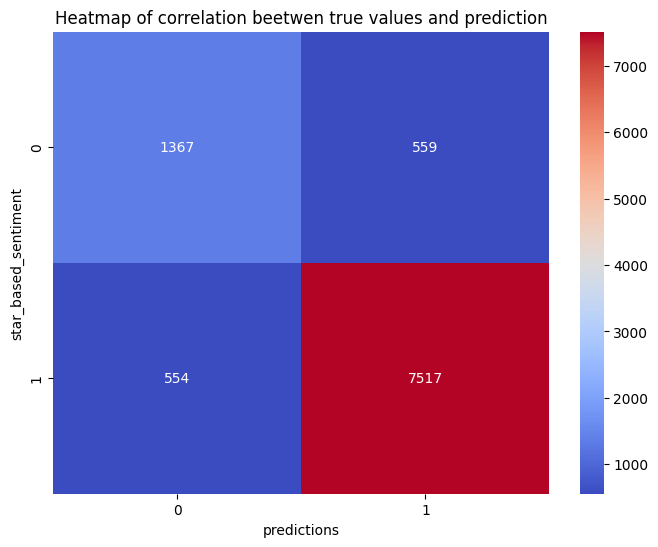

In [7]:
data["predictions"]=predict_on_roberta(data)
heatmap(data,"star_based_sentiment","predictions")

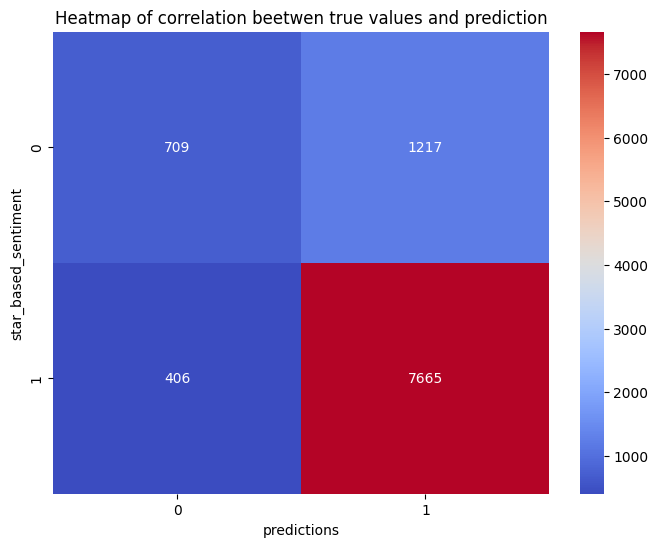

In [6]:
data["predictions"]=predict_on_vader(data)
heatmap(data,"star_based_sentiment","predictions")

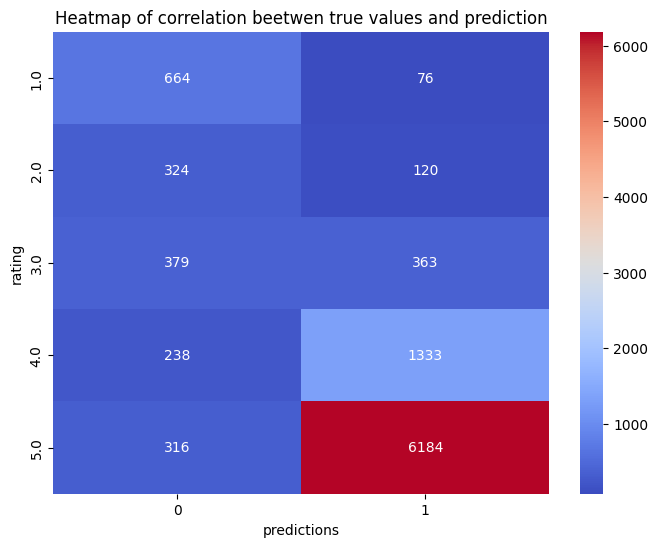

In [8]:
heatmap(data,"rating","predictions")